In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
list_ds = tf.data.Dataset.list_files('/home/vimal/Documents/mask/overall/input/*.xml')

In [3]:
img_height, img_width = 256, 256
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img,channels=3)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])
def decode_mask_img(img):
    # convert the compressed string to a 2D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=1)
    # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])
def process_path(file_path):
    file_path = tf.strings.regex_replace(file_path, '.xml', '.jpeg')
    mask_file_path = tf.strings.regex_replace(file_path, '.jpeg', '.jpeg')
    table_mask_file_path = tf.strings.regex_replace(mask_file_path,'input', 'table_mask')
    column_mask_file_path = tf.strings.regex_replace(mask_file_path,'input', 'column_mask')
    img = normalize(decode_img(tf.io.read_file(file_path)))
    table_mask = normalize(decode_mask_img(tf.io.read_file(table_mask_file_path)))
    column_mask = normalize(decode_mask_img(tf.io.read_file(column_mask_file_path)))
    return img, {"table_output" : table_mask, "column_output" : column_mask }

In [4]:
DATASET_SIZE = len(list(list_ds))
train_size = int(0.9 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)
train = list_ds.take(train_size)
test = list_ds.skip(train_size)
TRAIN_LENGTH = len(list(train))
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
train = train.shuffle(BUFFER_SIZE)
train = train.map(process_path,
num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test.map(process_path)
train_dataset = train.batch(BATCH_SIZE).repeat().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Table Mask', 'Column Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(256, 256, 3)


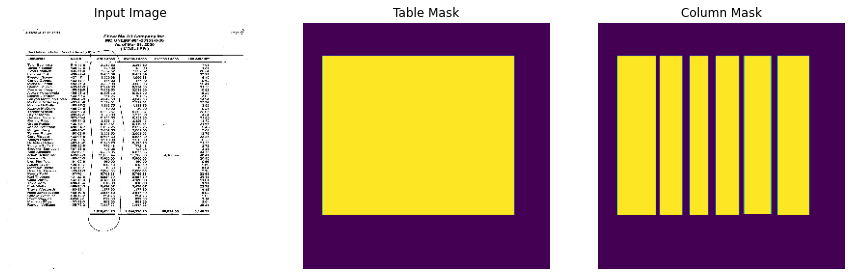

(256, 256, 3)


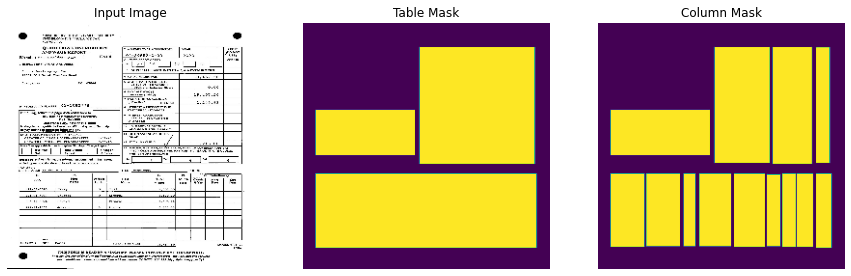

(256, 256, 3)


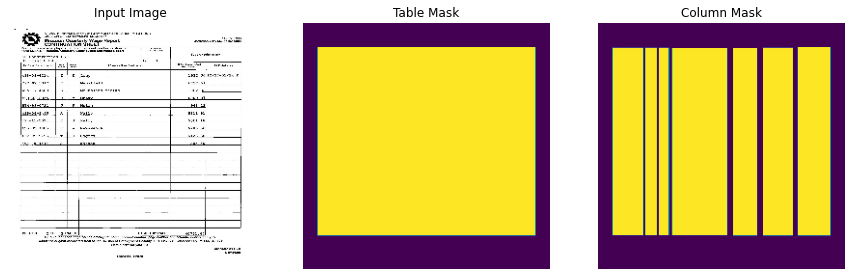

(256, 256, 3)


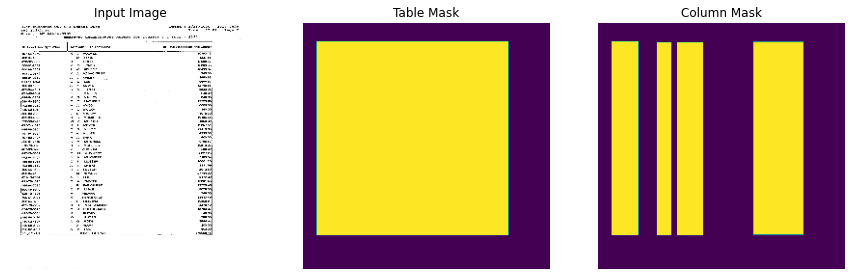

In [31]:
for image, mask in train.take(4):
    print(image.shape)
# print(mask.shape)
    display([image, mask['table_output'], mask['column_output']])

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D


In [8]:
class TableNet:
    @staticmethod
    def build_table_decoder(inputs, pool3, pool4):
        x = Conv2D(512, (1, 1), activation = 'relu', name='conv7_table')(inputs)
        x = UpSampling2D(size=(2, 2))(x)
        concatenated = Concatenate()([x, pool4])
        # concatenated = concatenate([x, pool4])
        x = UpSampling2D(size=(2,2))(concatenated)
        concatenated = Concatenate()([x, pool3])
        x = UpSampling2D(size=(2,2))(concatenated)
        x = UpSampling2D(size=(2,2))(x)
        last = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='table_output')
        x = last(x)
        return x
    
    def build_column_decoder(inputs, pool3, pool4):
        x = Conv2D(512, (1, 1), activation = 'relu',name='block7_conv1_column')(inputs)
        x = Dropout(0.8, name='block7_dropout_column')(x)
        x = Conv2D(512, (1, 1), activation = 'relu', name='block8_conv1_column')(x)
        x = UpSampling2D(size=(2, 2))(x)
        concatenated = Concatenate()([x, pool4])
        # concatenated = concatenate([x, pool4])
        x = UpSampling2D(size=(2,2))(concatenated)
        concatenated = Concatenate()([x, pool3])
        x = UpSampling2D(size=(2,2))(concatenated)
        x = UpSampling2D(size=(2,2))(x)
        last = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='column_output')
        x = last(x)
        return x
    @staticmethod
    def vgg_base(inputs):
        base_model = tf.keras.applications.vgg19.VGG19(input_shape=[256, 256, 3],include_top=False, weights='imagenet')
        layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
        layers = [base_model.get_layer(name).output for name in layer_names]
        pool_layers_model = Model(inputs=base_model.input, outputs=layers,name='VGG-19')
        pool_layers_model.trainable = False
        return pool_layers_model(inputs)
    @staticmethod
    def build():
        inputShape = (256, 256, 3)
        inputs = Input(shape=inputShape, name='input')
        pool_layers = TableNet.vgg_base(inputs)
        x = Conv2D(512, (1, 1), activation = 'relu',name='block6_conv1')(pool_layers[2])
        x = Dropout(0.8, name='block6_dropout1')(x)
        x = Conv2D(512, (1, 1), activation = 'relu', name='block6_conv2')(x)
        x = Dropout(0.8, name = 'block6_dropout2')(x)
        table_mask = TableNet.build_table_decoder(x, pool_layers[0], pool_layers[1])
        column_mask = TableNet.build_column_decoder(x, pool_layers[0],pool_layers[1])
        model = Model(inputs=inputs,outputs=[table_mask, column_mask],name="tablenet")
        return model
    

In [9]:
import graphviz
import pydot

In [10]:
model = TableNet.build()
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [11]:
losses = {
"table_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
"column_output": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}
lossWeights = {"table_output": 1.0, "column_output": 1.0}
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,epsilon=1e-08),
loss=losses,
metrics=['accuracy'],
loss_weights=lossWeights)

In [12]:
def create_mask(pred_mask1, pred_mask2):
    pred_mask1 = tf.argmax(pred_mask1, axis=-1)
    pred_mask1 = pred_mask1[..., tf.newaxis]
    pred_mask2 = tf.argmax(pred_mask2, axis=-1)
    pred_mask2 = pred_mask2[..., tf.newaxis]
    return pred_mask1[0], pred_mask2[0]

In [13]:
for image, mask in train_dataset.take(1):
    sample_image, sample_mask1, sample_mask2 = image, mask['table_output'],mask['column_output']
    def show_predictions(dataset=None, num=1):
        if dataset:
            for image, (mask1, mask2) in dataset.take(num):
                pred_mask1, pred_mask2 = model.predict(image, verbose=1)
                table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
                display([image[0], table_mask, column_mask])
        else:
            pred_mask1, pred_mask2 = model.predict(sample_image, verbose=1)
            table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
            display([sample_image[0], table_mask, column_mask])

1/1 [==============================] - 1s 1s/step


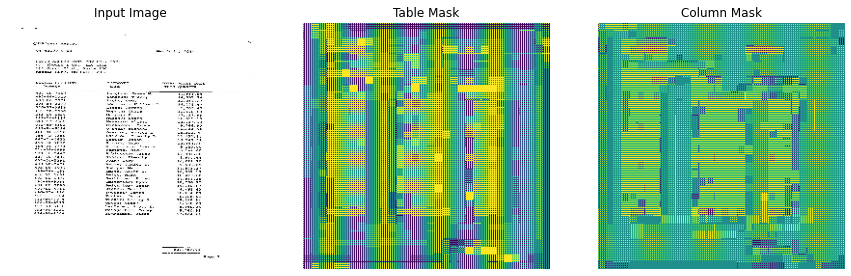

In [14]:
show_predictions()

In [15]:
from IPython.display import clear_output

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
        
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
filepath="mymodel_{epoch}",
save_best_only=True,
monitor="val_loss",
verbose=1,
)

early_stoping = tf.keras.callbacks.EarlyStopping(
monitor="val_loss",
patience=5,
verbose=1,
)
    

1/1 [==============================] - 1s 780ms/step


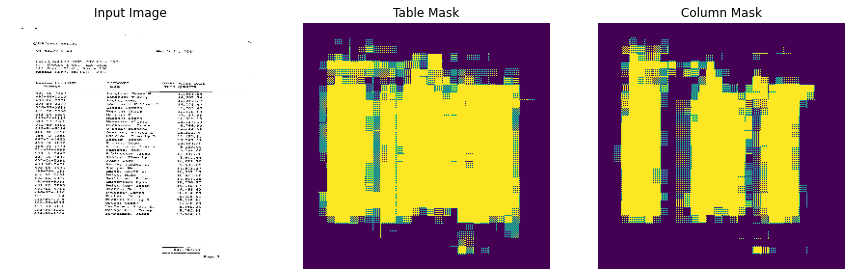


Sample Prediction after epoch 5


Epoch 00005: val_loss improved from 0.73712 to 0.69096, saving model to mymodel_5
INFO:tensorflow:Assets written to: mymodel_5/assets


In [16]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = test_size//BATCH_SIZE//VAL_SUBSPLITS
model_history = model.fit(train_dataset, epochs=EPOCHS,
steps_per_epoch=STEPS_PER_EPOCH,
validation_steps=VALIDATION_STEPS,
validation_data=test_dataset,
callbacks=[DisplayCallback(), model_checkpoint])

1/1 [==============================] - 1s 766ms/step


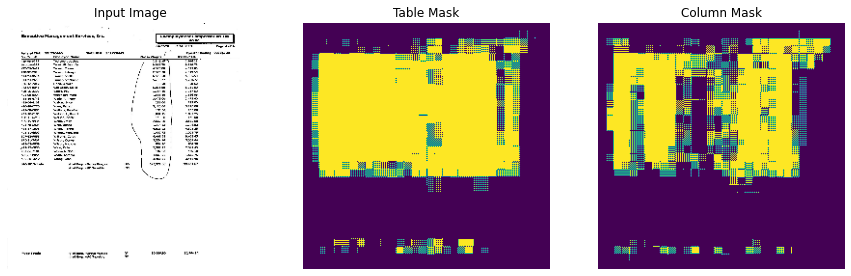

1/1 [==============================] - 1s 841ms/step


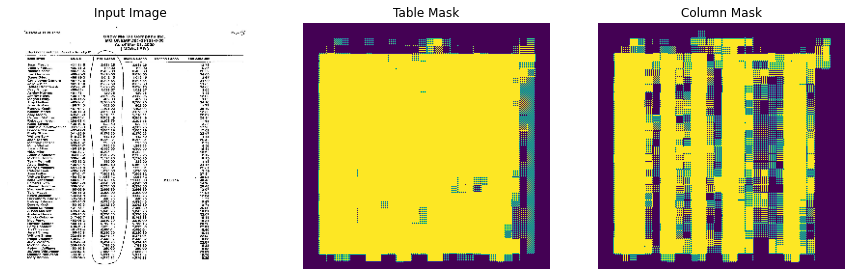

1/1 [==============================] - 1s 783ms/step


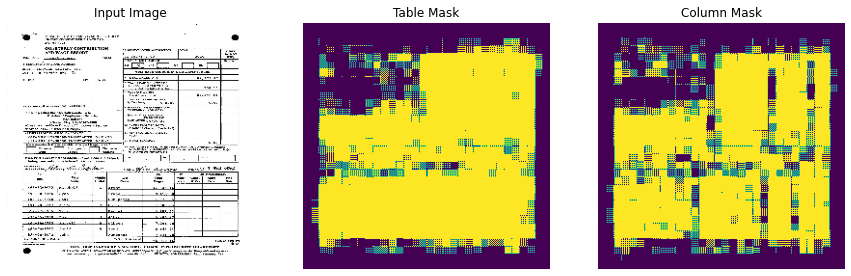

In [17]:
show_predictions(train_dataset, 3)


1/1 [==============================] - 1s 766ms/step


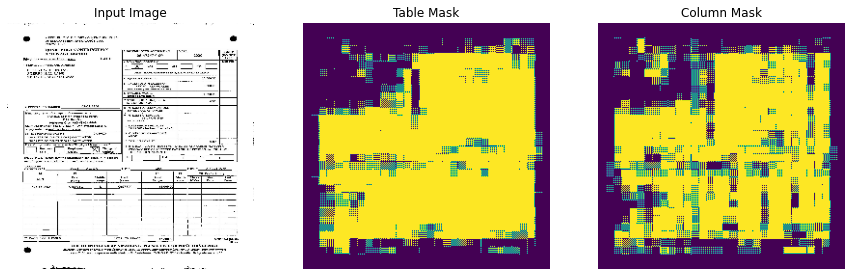

1/1 [==============================] - 1s 776ms/step


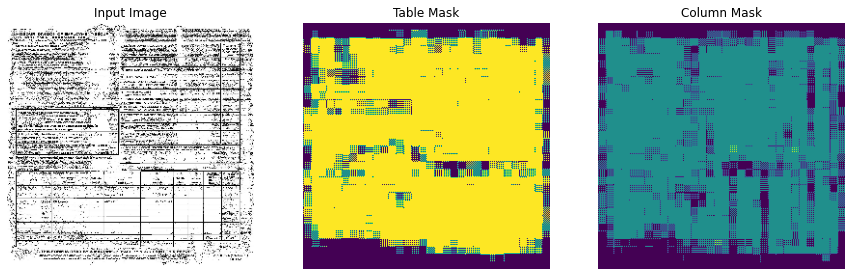

1/1 [==============================] - 1s 764ms/step


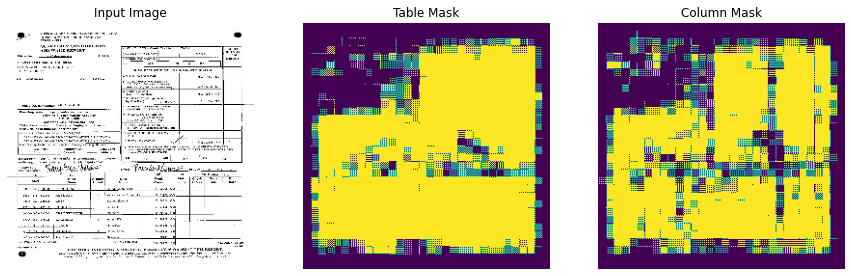

In [18]:
show_predictions(test_dataset, 3)


In [19]:
val = tf.data.Dataset.list_files('/home/vimal/Documents/mask/overall/validation/*.jpeg')


In [20]:
val_size = len(list(val))
val_size

26

1/1 [==============================] - 1s 779ms/step


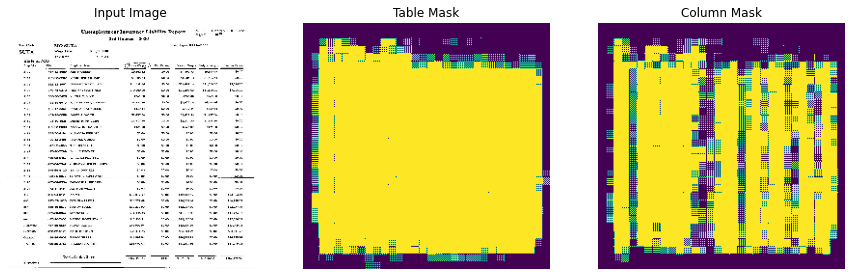

1/1 [==============================] - 1s 785ms/step


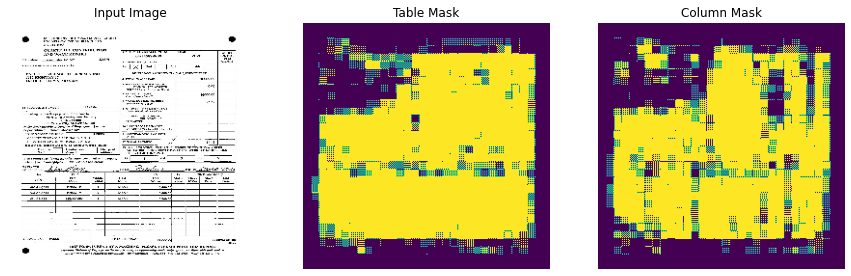

1/1 [==============================] - 1s 834ms/step


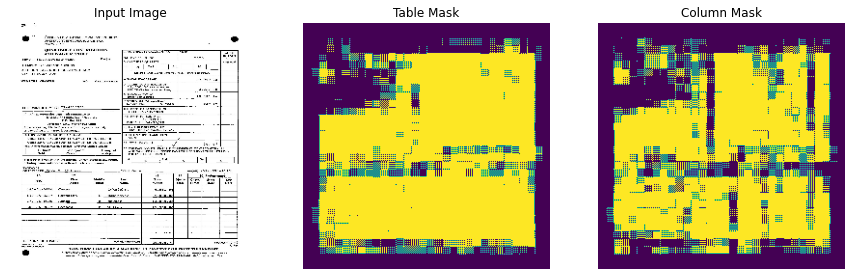

1/1 [==============================] - 1s 848ms/step


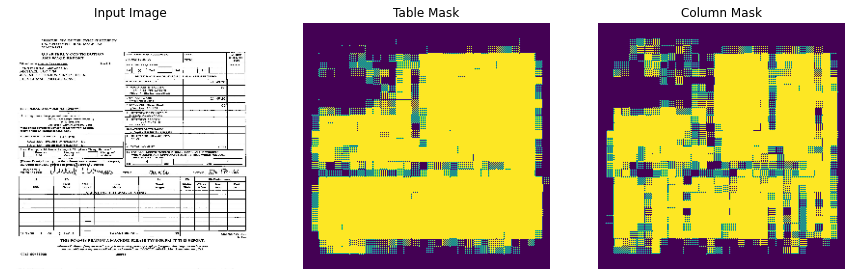

1/1 [==============================] - 1s 772ms/step


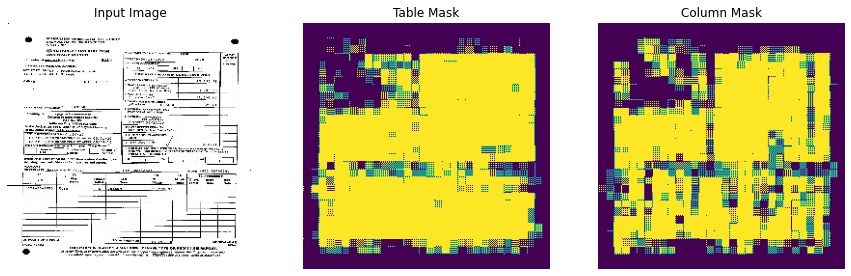

In [27]:
val_int = int(val_size)
test_val = val.take(val_int)
val_test = test_val.map(process_path)
val_dataset = val_test.batch(BATCH_SIZE)
show_predictions(val_dataset,5)

In [28]:
model.save('model_10')


INFO:tensorflow:Assets written to: model_10/assets
